In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from S00_utils import loadPickle, plot_res, store_results

In [3]:
df = pd.read_excel("output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [4]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

dfX = df[colsX]
dfY = df[colsY]

In [5]:
imgData = loadPickle("output/S22__2025-04-21-062139.pickle")

298


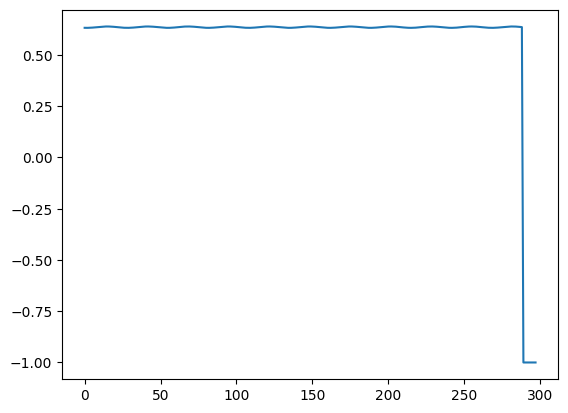

In [6]:
dfData = loadPickle("output/S11__2025-04-21-052441.pickle")
tsArr = [t[1] for t in dfData["ts"].values]
# Max length
maxTime = 0
for ts in tsArr:
    maxTime = len(ts) if maxTime < len(ts) else maxTime

print(maxTime)

# Scaling and Padding
# TODO: Needs to only calculate mean, std, min, max from training example.

SCALING_TYPE = "Min_Max"
# SCALING_TYPE = "STANDARDIZATION"

tsArrConcat = np.concatenate(tsArr)
if SCALING_TYPE == "STANDARDIZATION":
    meanVal = np.mean(tsArrConcat)
    stdVal = np.std(tsArrConcat)
elif SCALING_TYPE == "Min_Max":
    maxVal = np.max(tsArrConcat)
    minVal = np.min(tsArrConcat)

# Shape = (Batch, Time, Features)
TsData_std = np.zeros((dfData.shape[0], maxTime, 1))
for idx, ts in enumerate(tsArr):
    if SCALING_TYPE == "STANDARDIZATION":
        ts_std = (ts - meanVal) / stdVal
    elif SCALING_TYPE == "Min_Max":
        ts_std = (ts - minVal) / (maxVal - minVal)

    TsData_std[idx, : len(ts), 0] = ts_std  # Scaling
    TsData_std[idx, len(ts) :, 0] = -1  # Padding

plt.plot(TsData_std[0, :])

In [7]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0, test_size=0.30)
idxs = np.arange(df.shape[0])
idxTrain, idxTest = next(cv.split(X=idxs))
print(idxTrain)
print(idxTest)

[60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40 38  5 91 59  0 34
 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29 49 97 98 69 20 94
 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76]


In [8]:
dfX_train = dfX.iloc[idxTrain, :]
dfX_test = dfX.iloc[idxTest, :]
dfY_train = dfY.iloc[idxTrain, :]
dfY_test = dfY.iloc[idxTest, :]
img_train = imgData[idxTrain, :, :, :]
img_test = imgData[idxTest, :, :, :]
Ts_train_std = TsData_std[idxTrain, :]
Ts_test_std = TsData_std[idxTest, :]

In [9]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(dfX_train)
X_test_std = scX.transform(dfX_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(dfY_train)
Y_test_std = scY.transform(dfY_test)

In [10]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)
Ts_train_std = torch.tensor(Ts_train_std, dtype=torch.float32)
Ts_test_std = torch.tensor(Ts_test_std, dtype=torch.float32)

In [11]:
from torchvision import transforms
import torch.nn.functional as F

img_train_torch = torch.from_numpy(img_train).float()
img_test_torch = torch.from_numpy(img_test).float()

# Normalize
mean = torch.mean(img_train_torch, dim=(0, 2, 3))
std = torch.std(img_train_torch, dim=(0, 2, 3))
print(mean, std)

normalize = transforms.Normalize(mean=[mean], std=[std])
img_train_torch_norm = torch.stack([normalize(img) for img in img_train_torch])
img_test_torch_norm = torch.stack([normalize(img) for img in img_test_torch])
print(img_train_torch_norm.shape)
print(img_test_torch_norm.shape)

# Resize
new_size = (32, 32)
img_train_torch_norm_resize = F.interpolate(
    img_train_torch_norm, size=new_size, mode="bilinear", align_corners=False
)
img_test_torch_norm_resize = F.interpolate(
    img_test_torch_norm, size=new_size, mode="bilinear", align_corners=False
)
print(img_train_torch_norm_resize.shape)
print(img_test_torch_norm_resize.shape)

tensor([0.1284]) tensor([1.3103])
torch.Size([70, 1, 64, 200])
torch.Size([30, 1, 64, 200])
torch.Size([70, 1, 32, 32])
torch.Size([30, 1, 32, 32])


In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64, 32)):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers += [nn.Linear(prev_dim, dim), nn.ReLU()]
            prev_dim = dim
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class CNN(nn.Module):
    def __init__(self, in_channels=1, out_features=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
        )
        self.fc = nn.Linear(32 * 4 * 4, out_features)

    def forward(self, x):
        return self.fc(self.features(x))


class AttentiveLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Sequential(nn.Linear(hidden_size, 1), nn.Softmax(dim=1))

    def forward(self, x):
        outputs, _ = self.lstm(x)  # (batch, seq_len, hidden_size)
        weights = self.attention(outputs)  # (batch, seq_len, 1)
        return torch.sum(weights * outputs, dim=1)


class FusionAttention(nn.Module):
    def __init__(self, feature_dims=32, num_modalities=3):
        super().__init__()
        self.query = nn.Parameter(torch.randn(feature_dims))
        self.keys = nn.Linear(feature_dims, feature_dims)
        self.values = nn.Linear(feature_dims, feature_dims)

    def forward(self, modalities):
        # modalities: list of (batch, feature_dims)
        stacked = torch.stack(
            modalities, dim=1
        )  # (batch, num_modalities, feature_dims)
        keys = self.keys(stacked)
        values = self.values(stacked)
        attn_scores = torch.matmul(keys, self.query) / (keys.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=1)
        return torch.sum(attn_weights.unsqueeze(-1) * values, dim=1)


class MultiModalRegressor(nn.Module):
    def __init__(self, mlp_dim, cnn_channels, lstm_input_size, output_size):
        super().__init__()
        self.mlp_branch = MLP(mlp_dim)
        self.cnn_branch = CNN(cnn_channels)
        self.lstm_branch = AttentiveLSTM(lstm_input_size)
        self.fusion = FusionAttention()
        self.regressor = nn.Sequential(
            nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, output_size)
        )

    def forward(self, mlp_x, cnn_x, lstm_x):
        mlp_feats = self.mlp_branch(mlp_x)
        cnn_feats = self.cnn_branch(cnn_x)
        lstm_feats = self.lstm_branch(lstm_x)
        fused = self.fusion([mlp_feats, cnn_feats, lstm_feats])
        return self.regressor(fused)

In [13]:
model = MultiModalRegressor(
    mlp_dim=dfX.shape[1], cnn_channels=1, lstm_input_size=1, output_size=3
)

In [14]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

MSE: 0.33
RMSE: 0.58


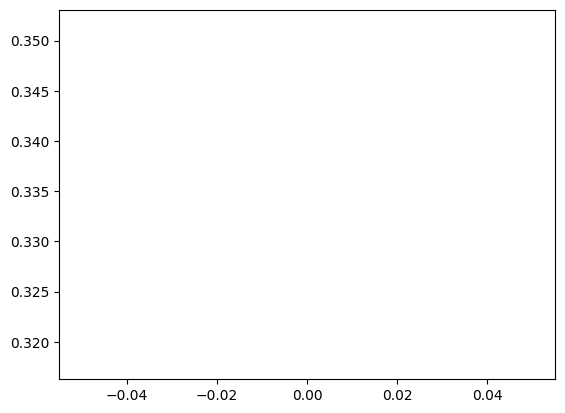

In [15]:
n_epochs = 1  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_std), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_std[start : start + batch_size]
            T_batch = Ts_train_std[start : start + batch_size]
            I_batch = img_train_torch_norm_resize[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch, I_batch, T_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_std, img_test_torch_norm_resize, Ts_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [16]:
Y_train_pred = model(X_train_std, img_train_torch_norm_resize, Ts_train_std)
Y_test_pred = model(X_test_std, img_test_torch_norm_resize, Ts_test_std)

In [17]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.129017,0.112394,-1.878910,-1.097113
1,0.362512,0.433175,-8.439313,-13.011280
2,0.633987,0.458457,-9.782848,-7.747299


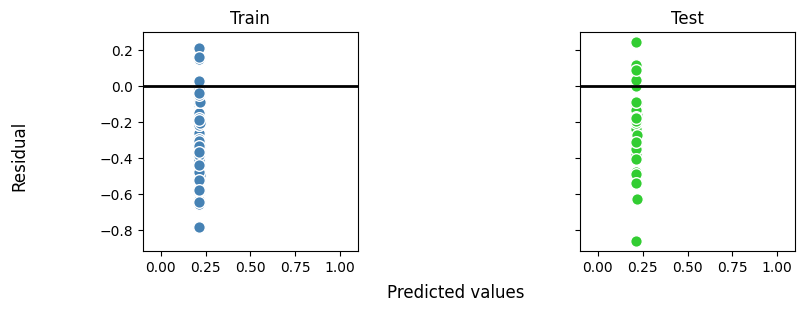

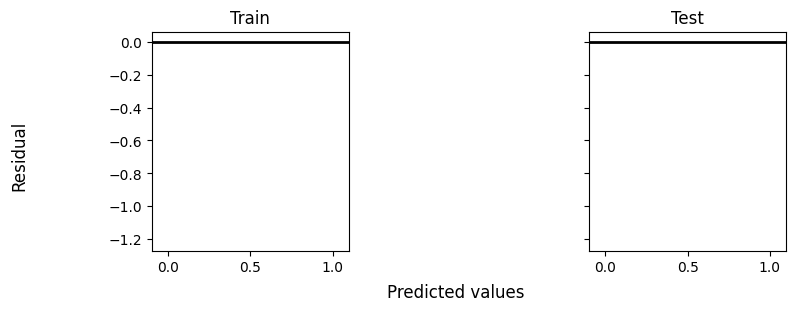

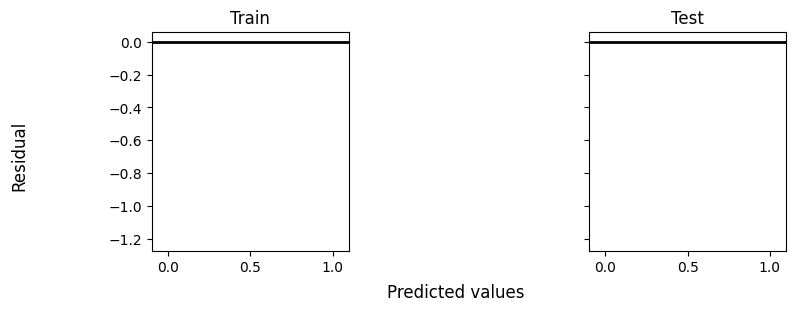

In [18]:
resArr = []
for i in range(dfY.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes

In [19]:
def visualize_attention(model, sample):
    with torch.no_grad():
        mlp_feats = model.mlp_branch(sample[0])
        cnn_feats = model.cnn_branch(sample[1])
        lstm_feats = model.lstm_branch(sample[2])
        
        # Get modality attention weights
        stacked = torch.stack([mlp_feats, cnn_feats, lstm_feats], dim=1)
        keys = model.fusion.keys(stacked)
        attn_scores = torch.matmul(keys, model.fusion.query) / (keys.size(-1)**0.5)
        weights = F.softmax(attn_scores, dim=1)
        
        plt.bar(['MLP', 'CNN', 'LSTM'], weights.squeeze().numpy())
        plt.title('Modality Attention Weights')

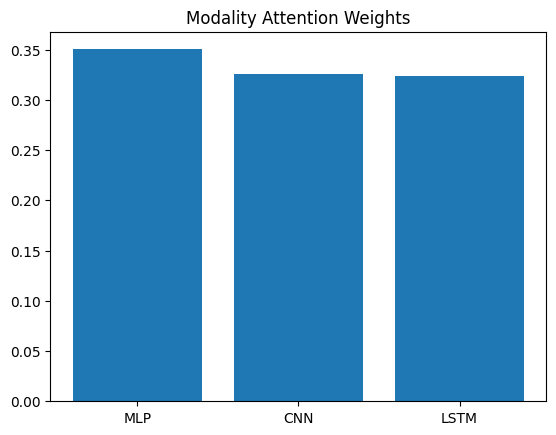

In [20]:
visualize_attention(model, (X_train_std[:1], img_train_torch_norm_resize[:1], Ts_train_std[:1]))

In [21]:
model

MultiModalRegressor(
  (mlp_branch): MLP(
    (net): Sequential(
      (0): Linear(in_features=47, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (cnn_branch): CNN(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): AdaptiveAvgPool2d(output_size=(4, 4))
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (fc): Linear(in_features=512, out_features=32, bias=True)
  )
  (lstm_branch): AttentiveLSTM(
    (lstm): LSTM(1, 32, batch_first=True)
    (attention): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): Softmax(dim=1)
    )
  )
  (fusion): FusionAttention(
    (keys): Linear(in_features=32, out_features

In [22]:
model.fusion

FusionAttention(
  (keys): Linear(in_features=32, out_features=32, bias=True)
  (values): Linear(in_features=32, out_features=32, bias=True)
)

In [23]:
model(X_train_std[:1], img_train_torch_norm_resize[:1], Ts_train_std[:1])

tensor([[ 0.2137, -0.2116, -0.2138]], grad_fn=<AddmmBackward0>)

In [24]:
model.fusion.keys

Linear(in_features=32, out_features=32, bias=True)

In [25]:
model.fusion.query

Parameter containing:
tensor([-0.8507,  0.7250,  0.0700,  0.9804,  1.3085,  1.1894, -0.4948, -1.6121,
         1.2690,  1.7068, -1.4095,  0.1605,  0.8183, -0.0511,  0.8170,  0.8800,
        -0.0176, -0.6307,  1.2220, -0.1045,  0.5516, -0.6153, -0.6907,  0.4784,
        -0.4948,  0.2064, -0.0290,  0.5361, -1.7714,  0.8890,  1.0430,  1.5097],
       requires_grad=True)

In [26]:
model.fusion.values

Linear(in_features=32, out_features=32, bias=True)

In [28]:
torch.matmul(model.fusion.keys, model.fusion.query)

TypeError: matmul(): argument 'input' (position 1) must be Tensor, not Linear

In [54]:
mlp = model.mlp_branch(X_train_std[:1])
cnn = model.cnn_branch(img_train_torch_norm_resize[:1])
lstm = model.lstm_branch(Ts_train_std[:1])
print(mlp.shape, cnn.shape)

torch.Size([1, 32]) torch.Size([1, 32])


In [55]:
stack = torch.stack([mlp, cnn, lstm], dim=1)
print(stack.shape)

torch.Size([1, 3, 32])


In [56]:
keys = model.fusion.keys(stack)
values = model.fusion.values(stack)
print(keys.shape, values.shape)

torch.Size([1, 3, 32]) torch.Size([1, 3, 32])


In [69]:
query = model.fusion.query
print(query.shape)

torch.Size([32])


In [58]:
scores = torch.matmul(keys, query)
print(scores.shape)
scores

torch.Size([1, 3])


tensor([[ 0.4498,  0.0440, -0.0007]], grad_fn=<UnsafeViewBackward0>)

In [59]:
weights = F.softmax(scores, dim=1)
print(weights.shape)
weights

torch.Size([1, 3])


tensor([[0.4341, 0.2893, 0.2766]], grad_fn=<SoftmaxBackward0>)

In [63]:
(weights.unsqueeze(-1)).shape

torch.Size([1, 3, 1])

In [64]:
values.shape

torch.Size([1, 3, 32])

In [65]:
(weights.unsqueeze(-1) * values).shape

torch.Size([1, 3, 32])

In [68]:
torch.sum((weights.unsqueeze(-1) * values), dim=1).shape

torch.Size([1, 32])